# Research on Job recommendatation model

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [53]:
df = pd.read_csv("../data/data_science_job_posts_2025_clean.csv")

In [54]:
def parse_salary_to_number(s):
    s = str(s)
    # Remove Euro sign and spaces
    s = s.replace("€", "").replace(" ", "")
    
    # If range like "70000-90000", take midpoint
    if "-" in s:
        parts = s.split("-")
        try:
            low = float(parts[0].replace(",", ""))
            high = float(parts[1].replace(",", ""))
            return (low + high) / 2.0
        except:
            return np.nan
    else:
        try:
            return float(s.replace(",", ""))
        except:
            return np.nan

df['salary_usd'] = df['salary'].apply(parse_salary_to_number)

# Drop rows where salary couldn't be parsed
df = df.dropna(subset=['salary_usd'])

print(df[['salary', 'salary_usd']].head())


                salary  salary_usd
0  €100,472 - €200,938    150705.0
1             €118,733    118733.0
2   €94,987 - €159,559    127273.0
3  €112,797 - €194,402    153599.5
4  €114,172 - €228,337    171254.5


  company_size company_size_group
0     €352.44B              large
1      155,030              large
2       25,930              large
3       34,690              large
4        1,800             medium
company_size_group
large     546
small     208
medium    172
Name: count, dtype: int64


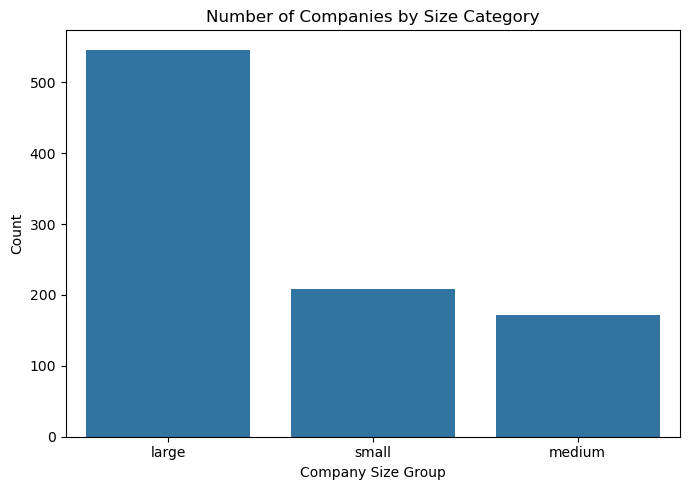

In [55]:
def company_size_group(size):
    size_str = str(size)
    
    # Case 1: values like "€352.44B" -> treat as very large
    if "€" in size_str or "b" in size_str.lower() or "m" in size_str.lower():
        return "large"
    
    # Case 2: numeric employee counts like "155,030"
    cleaned = size_str.replace(",", "")
    try:
        n = int(cleaned)
    except:
        return "unknown"
    
    # Thresholds for US-style company sizes
    if n < 1000:
        return "small"
    elif n < 10000:
        return "medium"
    else:
        return "large"

df['company_size_group'] = df['company_size'].apply(company_size_group)

# Drop 'unknown' if any
df = df[df['company_size_group'] != "unknown"]

print(df[['company_size', 'company_size_group']].head())
print(df['company_size_group'].value_counts())

# Count categories
size_counts = df['company_size_group'].value_counts().reset_index()
size_counts.columns = ['company_size_group', 'count']

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(
    data=size_counts,
    x='company_size_group',
    y='count'
)

plt.title("Number of Companies by Size Category")
plt.xlabel("Company Size Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [56]:
def clean_skills(s):
    # Convert "['python','sql']" → "python sql"
    s = str(s)
    s = s.replace("[", "").replace("]", "").replace("'", "")
    s = s.replace(",", " ")
    return s

df['skills_clean'] = df['skills'].apply(clean_skills)

# Text = job_title + skills
df['text'] = df['job_title'].astype(str) + " " + df['skills_clean'].astype(str)

print(df[['job_title', 'skills', 'skills_clean', 'text']].head())


        job_title                                             skills  \
0  data scientist  ['spark', 'r', 'python', 'scala', 'machine lea...   
1  data scientist  ['spark', 'r', 'python', 'sql', 'machine learn...   
2  data scientist  ['aws', 'git', 'python', 'docker', 'sql', 'mac...   
3  data scientist                             ['sql', 'r', 'python']   
4  data scientist                                                 []   

                                        skills_clean  \
0  spark  r  python  scala  machine learning  ten...   
1            spark  r  python  sql  machine learning   
2  aws  git  python  docker  sql  machine learnin...   
3                                     sql  r  python   
4                                                      

                                                text  
0  data scientist spark  r  python  scala  machin...  
1  data scientist spark  r  python  sql  machine ...  
2  data scientist aws  git  python  docker  sql  ...  
3         

In [57]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

y = df['salary_usd']
sensitive = df['company_size_group']   # small / medium / large


In [58]:
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 740
Test size: 186


In [59]:
baseline_reg = Ridge(alpha=1.0)
baseline_reg.fit(X_train, y_train)

y_pred_base = baseline_reg.predict(X_test)

mse_base = mean_squared_error(y_test, y_pred_base)
print("Baseline MSE:", mse_base)


Baseline MSE: 3701786544.297647


In [60]:
results_base = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_base,
    "company_size_group": s_test
})

print("Average TRUE salary by company size:")
print(results_base.groupby("company_size_group")['y_true'].mean())

print("\nAverage PREDICTED salary by company size (baseline):")
print(results_base.groupby("company_size_group")['y_pred'].mean())


Average TRUE salary by company size:
company_size_group
large     130651.220000
medium    123682.195652
small     157485.737500
Name: y_true, dtype: float64

Average PREDICTED salary by company size (baseline):
company_size_group
large     129439.981371
medium    131105.714587
small     147650.552857
Name: y_pred, dtype: float64




Large companies → much higher predicted salary than small
→ That’s bias by company_size.

In [61]:
#defining sample weights
def size_to_weight(group):
    if group == "large":
        return 0.5   # penalize big companies
    elif group == "medium":
        return 0.8
    else:  # small
        return 1.0   # full weight for small companies

train_weights = s_train.apply(size_to_weight)

print(train_weights.value_counts())

company_size_group
0.5    446
1.0    168
0.8    126
Name: count, dtype: int64


In [62]:
#Train fair model with sample weights
fair_reg = Ridge(alpha=1.0)
fair_reg.fit(X_train, y_train, sample_weight=train_weights)

y_pred_fair = fair_reg.predict(X_test)

mse_fair = mean_squared_error(y_test, y_pred_fair)
print("Fair Model MSE:", mse_fair)


Fair Model MSE: 4525710557.87331


In [63]:
#compare bias
results_fair = pd.DataFrame({
    "y_true": y_test,
    "y_pred_fair": y_pred_fair,
    "company_size_group": s_test
})

print("\nAverage PREDICTED salary by company size (baseline):")
print(results_base.groupby("company_size_group")['y_pred'].mean())

print("\nAverage PREDICTED salary by company size (FAIR):")
print(results_fair.groupby("company_size_group")['y_pred_fair'].mean())



Average PREDICTED salary by company size (baseline):
company_size_group
large     129439.981371
medium    131105.714587
small     147650.552857
Name: y_pred, dtype: float64

Average PREDICTED salary by company size (FAIR):
company_size_group
large     132834.639219
medium    133459.607131
small     152365.215868
Name: y_pred_fair, dtype: float64


In [64]:
#Convert predicted salaries into binary “high salary” label so that we can apply metrics
import numpy as np

threshold = y_test.median()

# True (actual) high salary
y_true_binary = (y_test >= threshold).astype(int)

# Baseline model predicted high salary
y_pred_base_binary = (y_pred_base >= threshold).astype(int)

# Fair model predicted high salary
y_pred_fair_binary = (y_pred_fair >= threshold).astype(int)


In [65]:
#use fairlearn to compute metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference
)

In [66]:
#baseline model fairness
mf_base = MetricFrame(
    metrics=selection_rate,
    y_true=y_true_binary,
    y_pred=y_pred_base_binary,
    sensitive_features=s_test
)

print("Baseline Selection Rate by Company Size Group:")
print(mf_base.by_group)


Baseline Selection Rate by Company Size Group:
company_size_group
large     0.300000
medium    0.456522
small     0.750000
Name: selection_rate, dtype: float64


In [67]:
#Demographic parity
dpd_base = demographic_parity_difference(
    y_true_binary,
    y_pred_base_binary,
    sensitive_features=s_test
)

dpr_base = demographic_parity_ratio(
    y_true_binary,
    y_pred_base_binary,
    sensitive_features=s_test
)

print("\nBaseline DPD:", dpd_base)
print("Baseline DPR:", dpr_base)



Baseline DPD: 0.45
Baseline DPR: 0.39999999999999997


In [68]:
#Equal opportunity
eod_fair = equalized_odds_difference(
    y_true_binary,
    y_pred_fair_binary,
    sensitive_features=s_test
)

print("Fair Model EOD:", eod_fair)


Fair Model EOD: 0.4090909090909091


In [69]:
from fairlearn.metrics import (
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    MetricFrame
)

import pandas as pd

print(" FAIRENESS METRICS (BEFORE vs AFTER)")
print("====================================\n")
# SELECTION RATE PER COMPANY SIZE GROUP
mf_base = MetricFrame(
    metrics=selection_rate,
    y_true=y_true_binary,
    y_pred=y_pred_base_binary,
    sensitive_features=s_test
)

mf_fair = MetricFrame(
    metrics=selection_rate,
    y_true=y_true_binary,
    y_pred=y_pred_fair_binary,
    sensitive_features=s_test
)

print("▶ Selection Rate by Company Size (Baseline):")
print(mf_base.by_group)
print("\n▶ Selection Rate by Company Size (Fair Model):")
print(mf_fair.by_group)

# DEMOGRAPHIC PARITY (Difference & Ratio)
dpd_base = demographic_parity_difference(
    y_true_binary, y_pred_base_binary, sensitive_features=s_test
)

dpd_fair = demographic_parity_difference(
    y_true_binary, y_pred_fair_binary, sensitive_features=s_test
)

dpr_base = demographic_parity_ratio(
    y_true_binary, y_pred_base_binary, sensitive_features=s_test
)

dpr_fair = demographic_parity_ratio(
    y_true_binary, y_pred_fair_binary, sensitive_features=s_test
)

print("\n▶ Demographic Parity Difference (DPD):")
print(f"Baseline DPD: {dpd_base:.4f}")
print(f"Fair Model DPD: {dpd_fair:.4f}")

print("\n▶ Demographic Parity Ratio (DPR):")
print(f"Baseline DPR: {dpr_base}")
print(f"Fair Model DPR: {dpr_fair}")

# EQUALIZED ODDS DIFFERENCE
eod_base = equalized_odds_difference(
    y_true_binary, y_pred_base_binary, sensitive_features=s_test
)

eod_fair = equalized_odds_difference(
    y_true_binary, y_pred_fair_binary, sensitive_features=s_test
)

print("\n▶ Equalized Odds Difference (EOD):")
print(f"Baseline EOD: {eod_base:.4f}")
print(f"Fair Model EOD: {eod_fair:.4f}")

 FAIRENESS METRICS (BEFORE vs AFTER)

▶ Selection Rate by Company Size (Baseline):
company_size_group
large     0.300000
medium    0.456522
small     0.750000
Name: selection_rate, dtype: float64

▶ Selection Rate by Company Size (Fair Model):
company_size_group
large     0.380000
medium    0.478261
small     0.725000
Name: selection_rate, dtype: float64

▶ Demographic Parity Difference (DPD):
Baseline DPD: 0.4500
Fair Model DPD: 0.3450

▶ Demographic Parity Ratio (DPR):
Baseline DPR: 0.39999999999999997
Fair Model DPR: 0.5241379310344828

▶ Equalized Odds Difference (EOD):
Baseline EOD: 0.5357
Fair Model EOD: 0.4091


In [70]:
# Build the fairness comparison table
comparison_table = pd.DataFrame({
    "Metric": [
        "Selection Rate (small)",
        "Selection Rate (medium)",
        "Selection Rate (large)",
        "Demographic Parity Difference (DPD)",
        "Demographic Parity Ratio (DPR)",
        "Equalized Odds Difference (EOD)"
    ],
    
    "Baseline": [
        mf_base.by_group.get("small", None),
        mf_base.by_group.get("medium", None),
        mf_base.by_group.get("large", None),
        dpd_base,
        dpr_base,
        eod_base
    ],
    
    "Fair Model": [
        mf_fair.by_group.get("small", None),
        mf_fair.by_group.get("medium", None),
        mf_fair.by_group.get("large", None),
        dpd_fair,
        dpr_fair,
        eod_fair
    ]
})

comparison_table


,Metric,Baseline,Fair Model
0,Selection Rate (small),0.750000,0.725000
1,Selection Rate (medium),0.456522,0.478261
2,Selection Rate (large),0.300000,0.380000
3,Demographic Parity Difference (DPD),0.450000,0.345000
4,Demographic Parity Ratio (DPR),0.400000,0.524138
5,Equalized Odds Difference (EOD),0.535714,0.409091


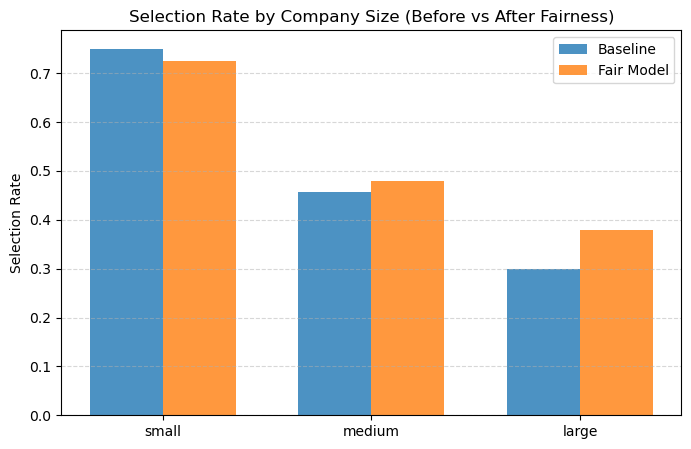

In [71]:
#Visualization : Selection rate bar chart
import matplotlib.pyplot as plt
import numpy as np

groups = ["small", "medium", "large"]
baseline_rates = [mf_base.by_group[g] for g in groups]
fair_rates = [mf_fair.by_group[g] for g in groups]

x = np.arange(len(groups))  # group positions
width = 0.35                # bar width

plt.figure(figsize=(8,5))
plt.bar(x - width/2, baseline_rates, width, label="Baseline", alpha=0.8)
plt.bar(x + width/2, fair_rates, width, label="Fair Model", alpha=0.8)

plt.xticks(x, groups)
plt.ylabel("Selection Rate")
plt.title("Selection Rate by Company Size (Before vs After Fairness)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


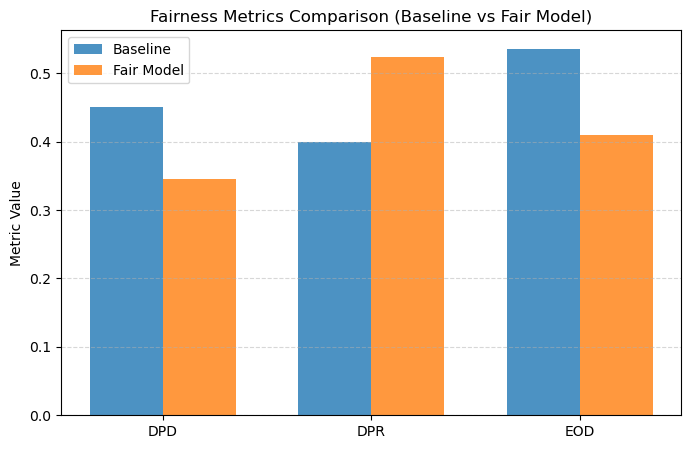

In [72]:
#Visualization: DPD, DPR, EOD Comparison Chart
metrics = ["DPD", "DPR", "EOD"]
baseline_vals = [dpd_base, dpr_base, eod_base]
fair_vals = [dpd_fair, dpr_fair, eod_fair]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, baseline_vals, width, label="Baseline", alpha=0.8)
plt.bar(x + width/2, fair_vals, width, label="Fair Model", alpha=0.8)

plt.xticks(x, metrics)
plt.ylabel("Metric Value")
plt.title("Fairness Metrics Comparison (Baseline vs Fair Model)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


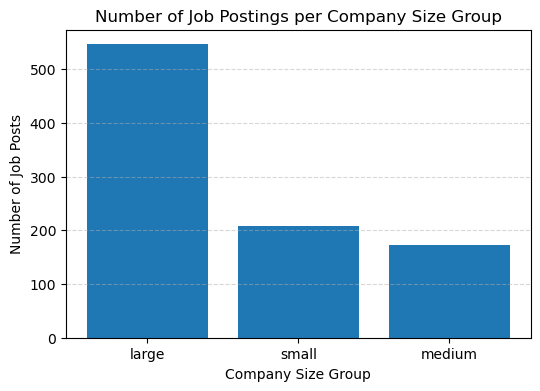

In [73]:
#job Count per Company Size Group
import matplotlib.pyplot as plt

group_counts = df['company_size_group'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values)
plt.xlabel("Company Size Group")
plt.ylabel("Number of Job Posts")
plt.title("Number of Job Postings per Company Size Group")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


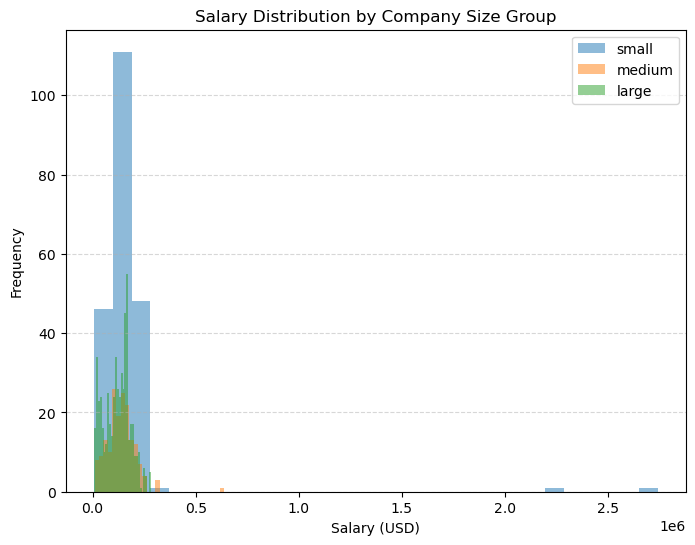

In [74]:
#Salary Distribution by Company Size (Histograms) - Shows how true salaries differ by size → evidence of underlying bias.
plt.figure(figsize=(8,6))

for group in ['small', 'medium', 'large']:
    subset = df[df['company_size_group'] == group]['salary_usd']
    plt.hist(subset, bins=30, alpha=0.5, label=group)

plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.title("Salary Distribution by Company Size Group")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
